# Presentation 2 — October 11th

### Objective: Find a way to export the epithelium

In [1]:
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import convolve

C:\Users\ashou\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Original Images

(-0.5, 4548.5, 5776.5, -0.5)

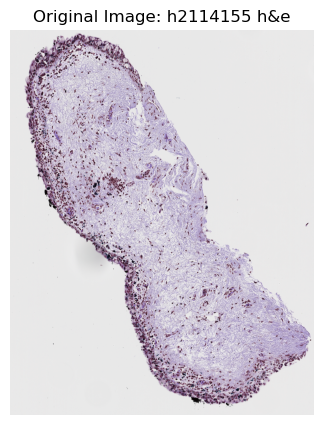

In [2]:
plt.figure(figsize=(10, 5))

original_image = cv2.imread("HighQualitySample.tif")
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image: h2114155 h&e')
plt.axis('off')

## Step 1: Alex's Code

C:\Users\ashou\AppData\Local\Temp\ipykernel_27556\3660241880.py:18: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (5777, 4549, 3) looks like that of an RGB image.
  threshold_value = threshold_otsu(smoothed_image)


Otsu's Threshold: 177


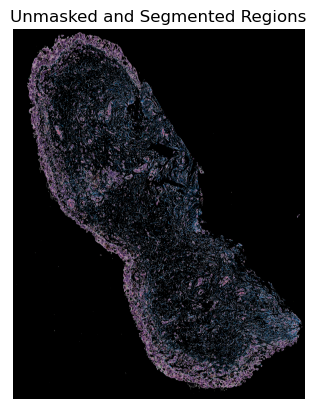

In [3]:
### Alex's code

#unmasked segmented regions

image = "HighQualitySample.tif"

img = Image.open(image)
img = np.array(img, dtype = np.uint8)

#smoothing
smoothed_image = gaussian_filter(img, sigma=1)
segmented_image = smoothed_image < 600

#thresholding
from skimage.filters import threshold_otsu

#otsu's
threshold_value = threshold_otsu(smoothed_image)
print("Otsu's Threshold:", threshold_value)

#segment the image
segmented_image = smoothed_image < threshold_value

unmasked_image = np.zeros_like(img)
unmasked_image[segmented_image] = img[segmented_image]
plt.imshow(unmasked_image, cmap='gray')
plt.title("Unmasked and Segmented Regions")
plt.axis('off')
plt.show()

## Step 2: Color Filtering and Otsu's Thresholding

- Applied HSV color filtering to isolate "purple" areas
- Used Otsu’s thresholding for segmentation
- **Outcome:** The method didn’t work as well as expected, as there is still a lot of noise within the epithelium layer

C:\Users\ashou\AppData\Local\Temp\ipykernel_27556\1371450136.py:24: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (5777, 4549, 3) looks like that of an RGB image.
  threshold_value = threshold_otsu(smoothed_image)


Otsu's Threshold: 186


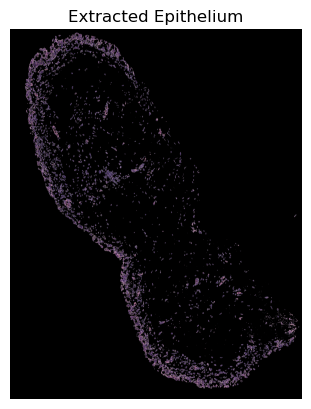

In [4]:
file = 'HighQualitySample.tif'
image = cv2.imread(file)

# Convert to HSV color space in order to isolate specific colors (setting up color-based segmentation)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower_purple = np.array([120, 50, 50])
upper_purple = np.array([170, 255, 255])

# Isolating "purple" areas
mask = cv2.inRange(hsv_image, lower_purple, upper_purple)

# Extracting the "purple" areas from the original image
purple_extracted = cv2.bitwise_and(image, image, mask=mask)

# Combining "purple" areas with a white background
white_background = np.full_like(image, 255)
final_image = np.where(purple_extracted != 0, purple_extracted, white_background)

# Smoothing
smoothed_image = gaussian_filter(final_image, sigma=2)

# Otsu's
threshold_value = threshold_otsu(smoothed_image)
print("Otsu's Threshold:", threshold_value)
segmented_image = smoothed_image < threshold_value

unmasked_image = np.zeros_like(final_image)
unmasked_image[segmented_image] = final_image[segmented_image]

plt.imshow(cv2.cvtColor(unmasked_image, cv2.COLOR_BGR2RGB))
plt.title("Extracted Epithelium")
plt.axis('off')
plt.show()

#final_output_image = Image.fromarray(cv2.cvtColor(unmasked_image, cv2.COLOR_BGR2RGB))
#final_output_image.save("AfterFilteringAndOtsu.tif", format="TIFF")

## Step 3: Neighborhood Analysis

- Developed a mask based on the number of purple pixels around each pixel
- Used a kernel to sum the number of neighboring pixels that are purple
- Set a threshold for sufficient neighbors and only kept purple pixels that met this threshold
- **Outcome:** 
    - Cleared up some noise, but not enough for a satisfactory extraction
    - The extracted epithelium layer is now too thin/bare

In [5]:
file = 'AfterFilteringAndOtsu.tif'
image = cv2.imread(file)

hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower_purple = np.array([120, 50, 50])
upper_purple = np.array([170, 255, 255])

purple_mask = cv2.inRange(hsv_image, lower_purple, upper_purple)

# Neighborhood Analysis: count the number of purple pixels around each pixel
# Create a 20x20 kernel to use as the "local neighborhood"
kernel = np.ones((20, 20), np.uint8)

# Count how many purple pixels are in the 20x20 neighborhood around each pixel
neighbor_count = convolve(purple_mask.astype(np.uint8), kernel)
neighbor_threshold = 150  # Manually tuned

# Keep only the purple pixels with sufficient # of neighbors
hysteresis_mask = np.where(neighbor_count >= neighbor_threshold, 255, 0).astype(np.uint8)

# Extract the epithelium layer
epithelium_outer_layer = cv2.bitwise_and(image, image, mask=hysteresis_mask)

# Combine the extracted epithelium outer layer with a white background
white_background = np.full_like(image, 255)
final_image = np.where(epithelium_outer_layer != 0, epithelium_outer_layer, white_background)

plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
plt.title("Extraction Using Hysteresis-Like Filtering")
plt.axis('off')
plt.show()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


## Step 4: Combining Alex’s and Group 2’s Code

- Combined Alex's code  with Group 2's method for contour-based filtering
- **Outcome:** Sccessfully extracted a high-quality image of (mostly) just the epithelium layer

- Contours: Group 2’s code finds the contours (boundaries) in the image using dilation and closing to merge nearby regions
- Contour Area: It filters out small contours, retaining only large contours, ensuring the focus remains on major structures
- Final Mask: The remaining large contours are applied to the unmasked image to highlight the epithelium layer

C:\Users\ashou\AppData\Local\Temp\ipykernel_27556\2494616859.py:18: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (5777, 4549, 3) looks like that of an RGB image.
  threshold_value = threshold_otsu(smoothed_image)


Otsu's Threshold: 177


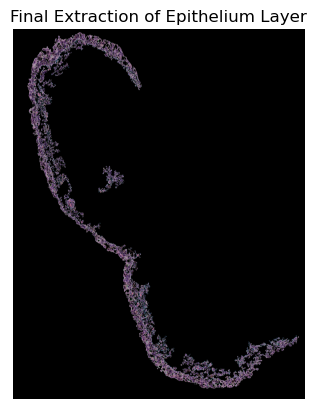

In [8]:
### Start of Alex's code

#unmasked segmented regions

image = "HighQualitySample.tif"

img = Image.open(image)
img = np.array(img, dtype = np.uint8)

#smoothing
smoothed_image = gaussian_filter(img, sigma=1)
segmented_image = smoothed_image < 600

#thresholding
from skimage.filters import threshold_otsu

#otsu's
threshold_value = threshold_otsu(smoothed_image)
print("Otsu's Threshold:", threshold_value)

#segment the image
segmented_image = smoothed_image < threshold_value

unmasked_image = np.zeros_like(img)
unmasked_image[segmented_image] = img[segmented_image]

### End of Alex's code



hsv_image = cv2.cvtColor(unmasked_image, cv2.COLOR_BGR2HSV)
lower_dark_purple = np.array([140, 50, 40])  
upper_dark_purple = np.array([160, 255, 150])
purple_mask = cv2.inRange(hsv_image, lower_dark_purple, upper_dark_purple)


### Start of Group 2's code

# Morphological operations and contour detection
# Explanation: Morphological operations first dilate and then erode an image, 
# helping to close small gaps and connect nearby regions of purple pixels
kernel = np.ones((15, 15), np.uint8)
closed_mask = cv2.morphologyEx(purple_mask, cv2.MORPH_CLOSE, kernel)

# Expanding "purple" areas using dilation
dilated_mask = cv2.dilate(closed_mask, kernel, iterations=1)

# Find contours by identifying the boundaries of the connected "white" areas
contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Contours with an area smaller than 30k will be ignored
min_contour_area = 30000 # Instead of 20,000

# Keeping only the large contours
large_contour_mask = np.zeros_like(purple_mask)
for contour in contours:
    if cv2.contourArea(contour) > min_contour_area:
        cv2.drawContours(large_contour_mask, [contour], -1, 255, thickness=cv2.FILLED)

# Keeping only the parts of the unmasked image that correspond to large contours
filtered_image = cv2.bitwise_and(unmasked_image, unmasked_image, mask = large_contour_mask)

### End of Group 2's code



fig, ax = plt.subplots(facecolor='white')  # Set the figure background to white

# Display the image with no axis
ax.imshow(filtered_image, cmap='gray')
ax.set_title("Final Extraction of Epithelium Layer")
ax.axis('off')  # Turn off axis

ax.set_facecolor('white')
plt.show()

# final_output_image = Image.fromarray(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
# final_output_image.save("FinalExtraction", format="TIFF")

C:\Users\ashou\AppData\Local\Temp\ipykernel_27556\248695625.py:17: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (5777, 4549, 3) looks like that of an RGB image.
  threshold_value = threshold_otsu(smoothed_image)


Otsu's Threshold: 177


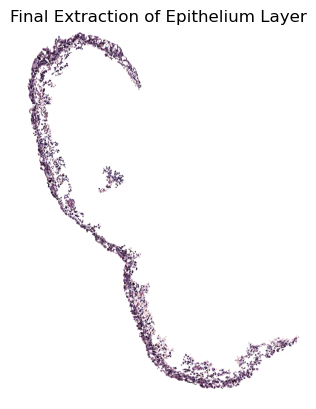

In [9]:
import numpy as np
import matplotlib.pyplot as plt

### Start of Alex's code

# unmasked segmented regions
image = "HighQualitySample.tif"

img = Image.open(image)
img = np.array(img, dtype=np.uint8)

# smoothing
smoothed_image = gaussian_filter(img, sigma=1)

# thresholding with Otsu's method
from skimage.filters import threshold_otsu
threshold_value = threshold_otsu(smoothed_image)
print("Otsu's Threshold:", threshold_value)

# segment the image
segmented_image = smoothed_image < threshold_value

unmasked_image = np.zeros_like(img)
unmasked_image[segmented_image] = img[segmented_image]

### End of Alex's code

hsv_image = cv2.cvtColor(unmasked_image, cv2.COLOR_BGR2HSV)
lower_dark_purple = np.array([140, 50, 40])  
upper_dark_purple = np.array([160, 255, 150])
purple_mask = cv2.inRange(hsv_image, lower_dark_purple, upper_dark_purple)

### Start of Group 2's code

# Morphological operations and contour detection
kernel = np.ones((15, 15), np.uint8)
closed_mask = cv2.morphologyEx(purple_mask, cv2.MORPH_CLOSE, kernel)

# Dilation
dilated_mask = cv2.dilate(closed_mask, kernel, iterations=1)

# Contour detection
contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Contours with an area smaller than 30k will be ignored
min_contour_area = 30000

# Keeping only the large contours
large_contour_mask = np.zeros_like(purple_mask)
for contour in contours:
    if cv2.contourArea(contour) > min_contour_area:
        cv2.drawContours(large_contour_mask, [contour], -1, 255, thickness=cv2.FILLED)

# Keeping only the parts of the unmasked image that correspond to large contours
filtered_image = cv2.bitwise_and(unmasked_image, unmasked_image, mask=large_contour_mask)

### End of Group 2's code


### New Section for Setting Background to White
# Convert black areas (background) to white
# Black is [0, 0, 0], we replace those pixels with white [255, 255, 255]
filtered_image_with_white_background = np.where(filtered_image == 0, 255, filtered_image)

### Plotting the image
fig, ax = plt.subplots(facecolor='white')  # Set the figure background to white

# Display the image with white background outside the epithelium layer
ax.imshow(filtered_image_with_white_background, cmap='gray')
ax.set_title("Final Extraction of Epithelium Layer")
ax.axis('off')  # Turn off axis

ax.set_facecolor('white')  # Ensures the background of the plot area is white as well
plt.show()

# Optionally save the final image
# final_output_image = Image.fromarray(cv2.cvtColor(filtered_image_with_white_background, cv2.COLOR_BGR2RGB))
# final_output_image.save("FinalExtraction", format="TIFF")


# Sampling

Running into difficulty of changing inside color to be black/white so we can distinguish which side of the sample is the outside of the tissue vs. stroma like Dr. Yamini wants.

## 5 sample extraction - random area

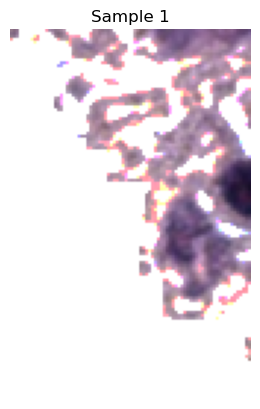

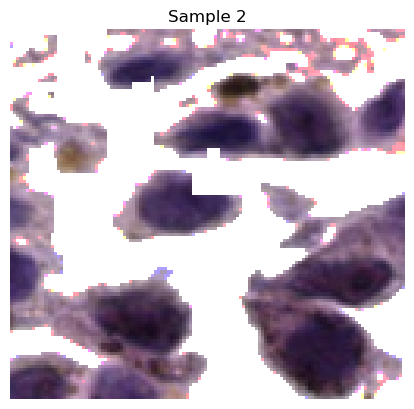

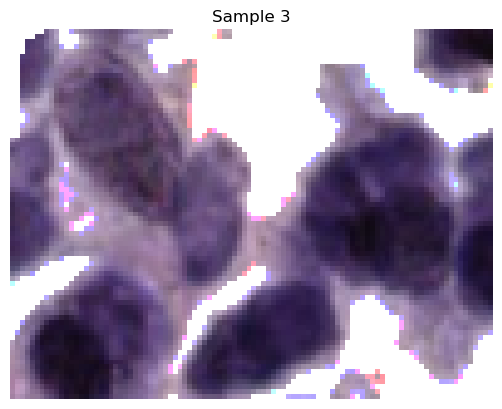

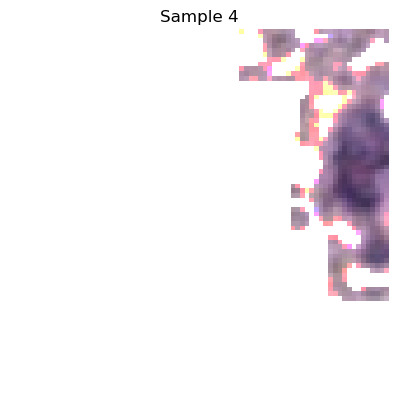

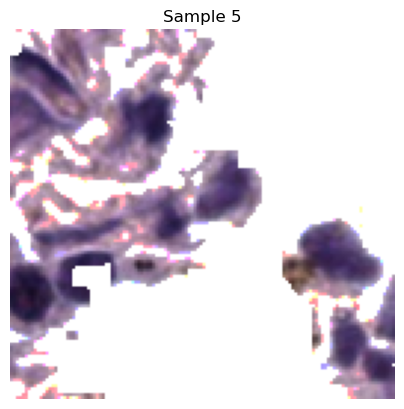

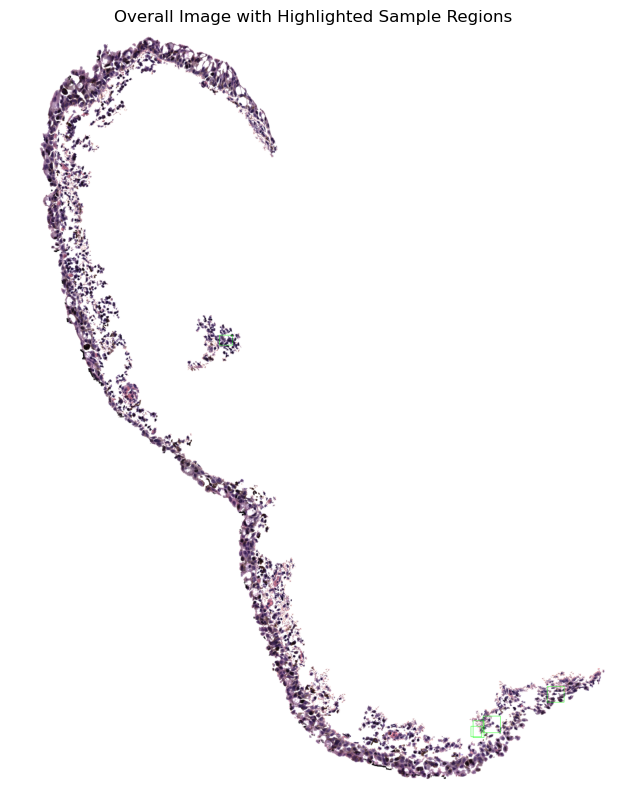

In [12]:
import cv2
import random
from PIL import Image

# Assuming 'filtered_image_with_white_background' is already generated
# Find contours again (since we already applied filtering)
contours, _ = cv2.findContours(large_contour_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Check if we have contours
if contours:
    # Copy of the full image to highlight sample locations
    highlighted_image = filtered_image_with_white_background.copy()

    # Generate 5 random samples from various contours
    num_samples = 5
    samples = []
    sample_boxes = []  # To store the coordinates of the samples

    for i in range(num_samples):
        # Randomly pick a contour to sample from
        selected_contour = random.choice(contours)

        # Get the bounding box of the selected contour
        x, y, w, h = cv2.boundingRect(selected_contour)

        # Randomly pick top-left corners for the sample within this bounding box
        sample_width = random.randint(50, min(150, w))  # Limit sample width to <= bounding box width
        sample_height = random.randint(50, min(150, h)) # Limit sample height to <= bounding box height

        # Ensure the sample fits within the contour's bounding box
        max_x = w - sample_width
        max_y = h - sample_height

        start_x = random.randint(0, max_x)
        start_y = random.randint(0, max_y)

        # Extract the sample from the bounding box of the selected contour
        sample = filtered_image_with_white_background[y + start_y:y + start_y + sample_height, 
                                                      x + start_x:x + start_x + sample_width]
        samples.append(sample)

        # Store the coordinates of the sample relative to the original image
        sample_boxes.append((x + start_x, y + start_y, sample_width, sample_height))

        # Display the sample
        plt.figure()
        plt.imshow(sample, cmap='gray')
        plt.title(f"Sample {i+1}")
        plt.axis('off')
        plt.show()

        # Optionally save the sample as an image
        sample_image = Image.fromarray(sample)
        sample_image.save(f"epithelium_sample_{i+1}.png")

    # Highlight the sample locations on the overall image
    for (start_x, start_y, sample_width, sample_height) in sample_boxes:
        # Draw a rectangle around the sample region (green color, thickness 2)
        cv2.rectangle(highlighted_image, (start_x, start_y), 
                      (start_x + sample_width, start_y + sample_height), 
                      (0, 255, 0), 2)

    # Plot the highlighted image with the sample boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(highlighted_image, cmap='gray')
    plt.title("Overall Image with Highlighted Sample Regions")
    plt.axis('off')
    plt.show()

else:
    print("No contours found in the image!")


Right idea, but does not cover all the way up to edge like the sampling requirements need.

## Attempt to get wider samples 

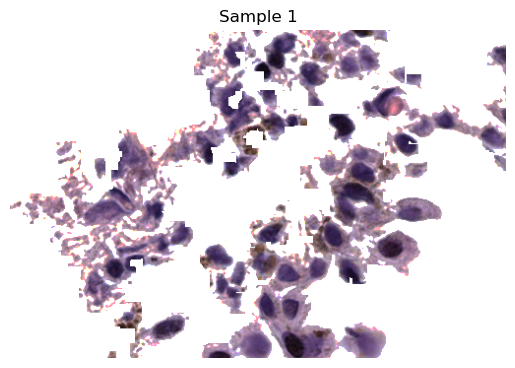

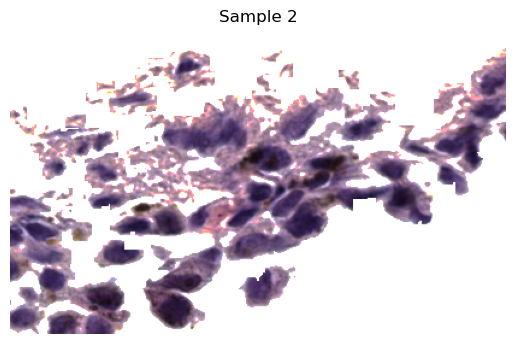

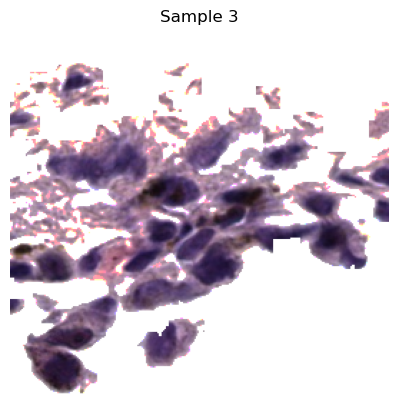

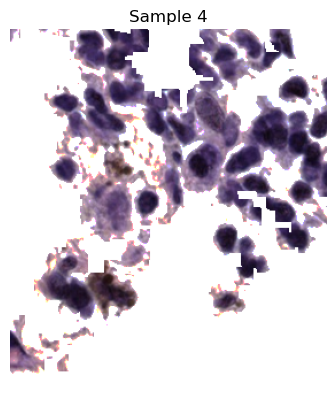

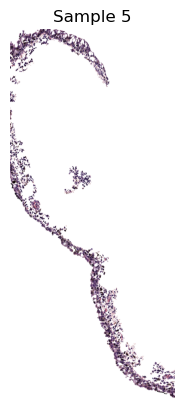

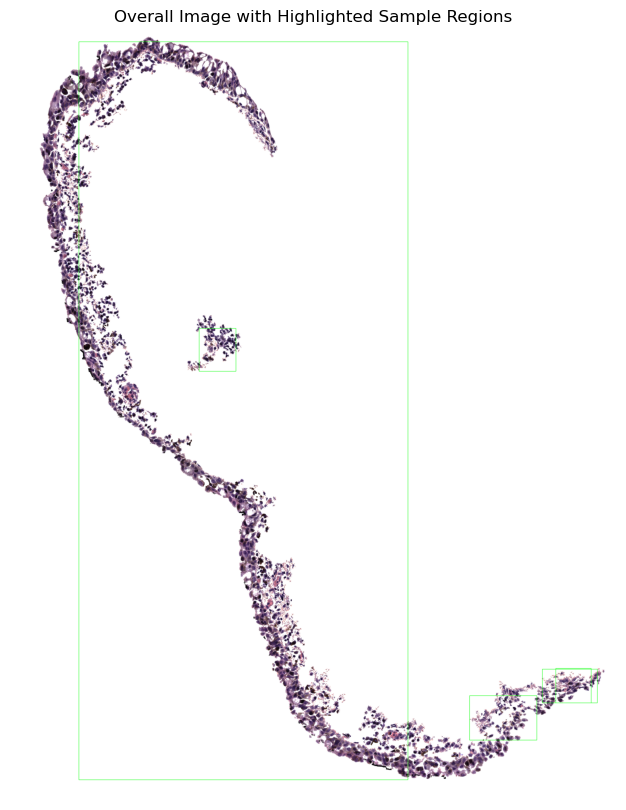

In [14]:
# Assuming 'filtered_image_with_white_background' is already generated
# Find contours again (since we already applied filtering)
contours, _ = cv2.findContours(large_contour_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Check if we have contours
if contours:
    # Copy of the full image to highlight sample locations
    highlighted_image = filtered_image_with_white_background.copy()

    # Generate 5 random samples from various contours
    num_samples = 5
    samples = []
    sample_boxes = []  # To store the coordinates of the samples

    for i in range(num_samples):
        # Randomly pick a contour to sample from
        selected_contour = random.choice(contours)

        # Get the bounding box of the selected contour
        x, y, w, h = cv2.boundingRect(selected_contour)

        # Generate wider samples, covering a larger width and up to the bottom of the epithelium
        sample_width = random.randint(int(w * 0.5), w)  # At least 50% of the bounding box width
        sample_height = random.randint(int(h * 0.5), h) # At least 50% of the bounding box height

        # For vertical range, extend the height to the bottom edge of the epithelium
        start_x = random.randint(0, w - sample_width)
        start_y = random.randint(0, h - sample_height)

        # Extract the sample from the bounding box of the selected contour
        sample = filtered_image_with_white_background[y + start_y:y + h, 
                                                      x + start_x:x + start_x + sample_width]
        samples.append(sample)

        # Store the coordinates of the sample relative to the original image
        sample_boxes.append((x + start_x, y + start_y, sample_width, h - start_y))  # Extend to bottom

        # Display the sample
        plt.figure()
        plt.imshow(sample, cmap='gray')
        plt.title(f"Sample {i+1}")
        plt.axis('off')
        plt.show()

        # Optionally save the sample as an image
        sample_image = Image.fromarray(sample)
        sample_image.save(f"epithelium_sample_{i+1}.png")

    # Highlight the sample locations on the overall image
    for (start_x, start_y, sample_width, sample_height) in sample_boxes:
        # Draw a rectangle around the sample region (green color, thickness 2)
        cv2.rectangle(highlighted_image, (start_x, start_y), 
                      (start_x + sample_width, start_y + sample_height), 
                      (0, 255, 0), 2)

    # Plot the highlighted image with the sample boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(highlighted_image, cmap='gray')
    plt.title("Overall Image with Highlighted Sample Regions")
    plt.axis('off')
    plt.show()

else:
    print("No contours found in the image!")


Incorrectly overcorrected and sampled too large on one sample. Other samples improved.

## Tilting sample regions

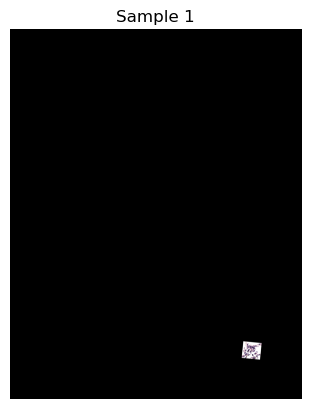

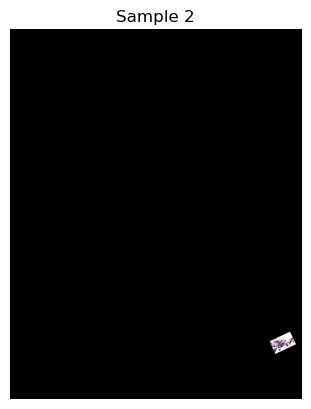

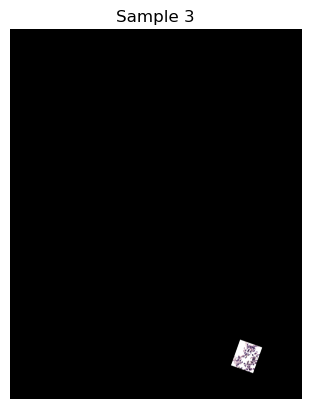

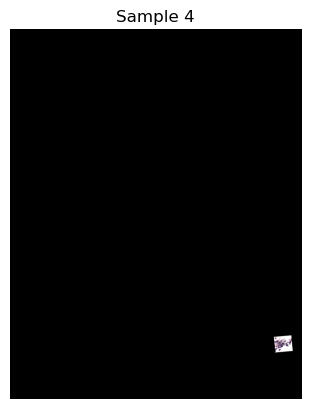

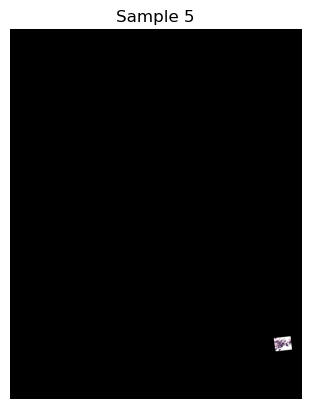

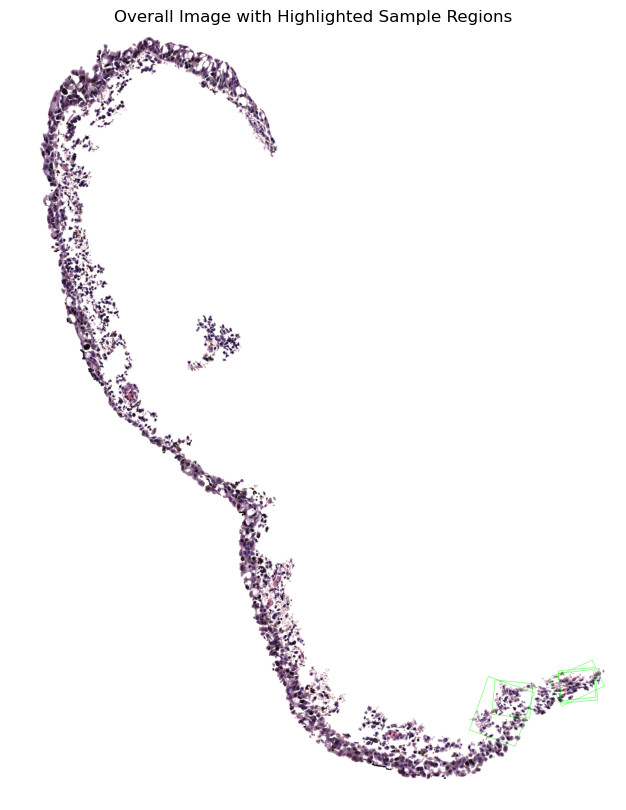

In [30]:
# Assuming 'filtered_image_with_white_background' is already generated
# Find contours again (since we already applied filtering)
contours, _ = cv2.findContours(large_contour_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Check if we have contours
if contours:
    # Copy of the full image to highlight sample locations
    highlighted_image = filtered_image_with_white_background.copy()

    # Generate 5 random tilted samples from various contours
    num_samples = 5
    samples = []
    sample_boxes = []  # To store the coordinates of the samples

    for i in range(num_samples):
        # Randomly pick a contour to sample from
        selected_contour = random.choice(contours)

        # Get the bounding box of the selected contour
        x, y, w, h = cv2.boundingRect(selected_contour)

        # Generate sample dimensions
        sample_width = random.randint(int(w * 0.5), w)  # At least 50% of the bounding box width
        sample_height = random.randint(int(h * 0.5), h)  # At least 50% of the bounding box height

        # Randomly choose a position for the sample
        start_x = random.randint(0, w - sample_width)
        start_y = random.randint(0, h - sample_height)

        # Randomly choose an angle to tilt the rectangle
        angle = random.uniform(-30, 30)  # Random angle between -30 and 30 degrees

        # Calculate the center for rotation
        center_x = x + start_x + sample_width / 2
        center_y = y + start_y + sample_height / 2

        # Calculate the corner points of the tilted rectangle
        corners = []
        for dx in [-sample_width / 2, sample_width / 2]:
            for dy in [-sample_height / 2, sample_height / 2]:
                # Rotate the point around the center
                rotated_x = center_x + dx * np.cos(np.radians(angle)) - dy * np.sin(np.radians(angle))
                rotated_y = center_y + dx * np.sin(np.radians(angle)) + dy * np.cos(np.radians(angle))
                corners.append((int(rotated_x), int(rotated_y)))

        # Convert the list of corners to a numpy array and sort them in a consistent order
        corners = np.array(corners, dtype=np.int32)

        # Sort corners in clockwise order
        center = np.mean(corners, axis=0)
        sorted_corners = sorted(corners, key=lambda p: np.arctan2(p[1] - center[1], p[0] - center[0]))
        sorted_corners = np.array(sorted_corners)

        # Create a mask for the tilted rectangle
        sample_mask = np.zeros_like(filtered_image_with_white_background)
        cv2.fillConvexPoly(sample_mask, sorted_corners, (255, 255, 255))

        # Extract the sample from the image using the mask
        tilted_sample = cv2.bitwise_and(filtered_image_with_white_background, sample_mask)

        # Store the sample
        samples.append(tilted_sample)

        # Store the coordinates of the sample for highlighting
        sample_boxes.append(sorted_corners)

        # Display the sample
        plt.figure()
        plt.imshow(tilted_sample, cmap='gray')
        plt.title(f"Sample {i + 1}")
        plt.axis('off')
        plt.show()

        # Optionally save the sample as an image
        sample_image = Image.fromarray(tilted_sample)
        sample_image.save(f"epithelium_sample_{i + 1}.png")

    # Highlight the sample locations on the overall image
    for corners in sample_boxes:
        # Draw the tilted polygon around the sample region (green color, thickness 2)
        cv2.polylines(highlighted_image, [corners], isClosed=True, color=(0, 255, 0), thickness=2)

    # Plot the highlighted image with the sample boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(highlighted_image, cmap='gray')
    plt.title("Overall Image with Highlighted Sample Regions")
    plt.axis('off')
    plt.show()

else:
    print("No contours found in the image!")


# Problems to fix

- Sampling is very inconsistent, running the code sometimes achieves good looking samples, other times does not.
- Background color to distinguish interior and exterior
- Height and width is still not covering as much of the epithelium as it can in some samples. 
- Need a way to automatically detect the right tilt because right now it's just a random angle...
- Contour detection seems to only detect in the bottom right and the middle .